# Preprocessing using Scanpy

Following the Scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html and partly this workshop: https://chanzuckerberg.github.io/scRNA-python-workshop/preprocessing/01-basic-qc.html

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(6, 4))
sc.settings.verbosity = 3

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.2 scipy==1.5.0 pandas==0.25.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


Load data into a pandas Dataframe and convert into an AnnData object:

In [3]:
dataset = 'E14_hom'

In [4]:
data = pd.read_csv('../data/' + dataset + '.csv', index_col=0)

In [5]:
adata = sc.AnnData(X=data.T)
print(adata)

AnnData object with n_obs × n_vars = 4446 × 30213


## Quality Control

Show the genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


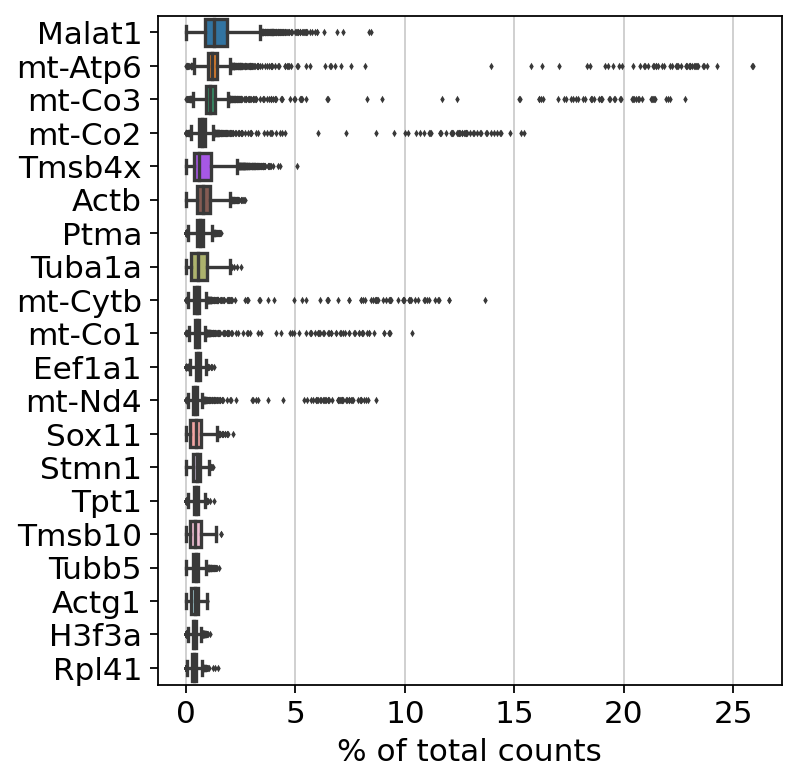

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Basic filltering

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 44 cells that have less than 200 genes expressed
filtered out 13314 genes that are detected in less than 3 cells


### Mitochondrial genes

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)  # compute QC metrics

In [9]:
print(adata)

AnnData object with n_obs × n_vars = 4402 × 16899
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


### Plot QC measures - violin plots

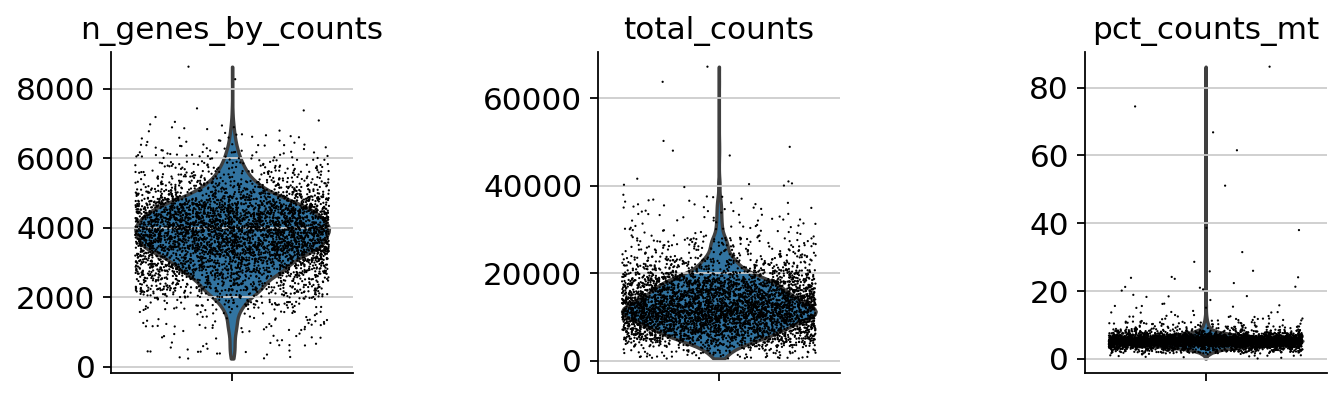

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

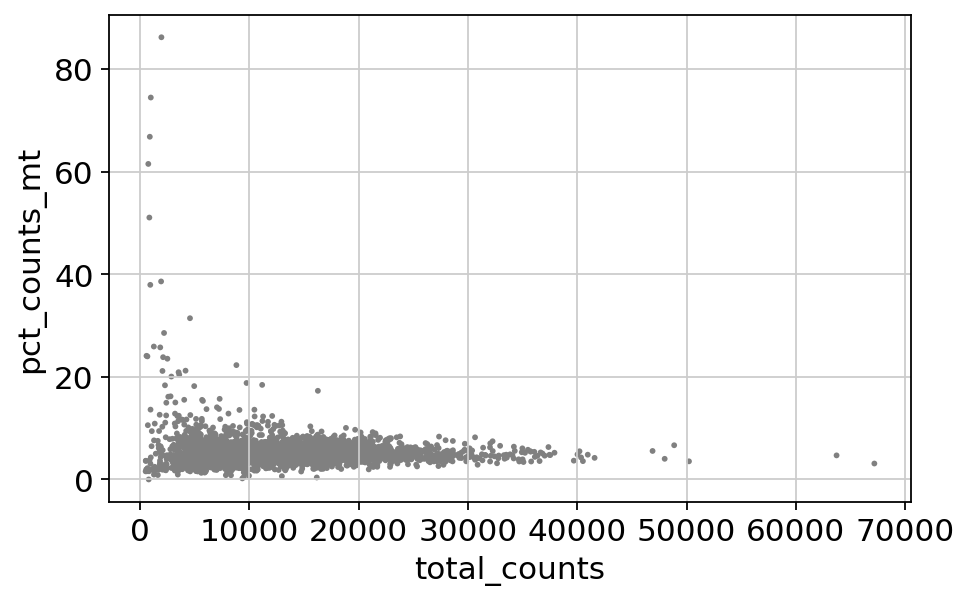

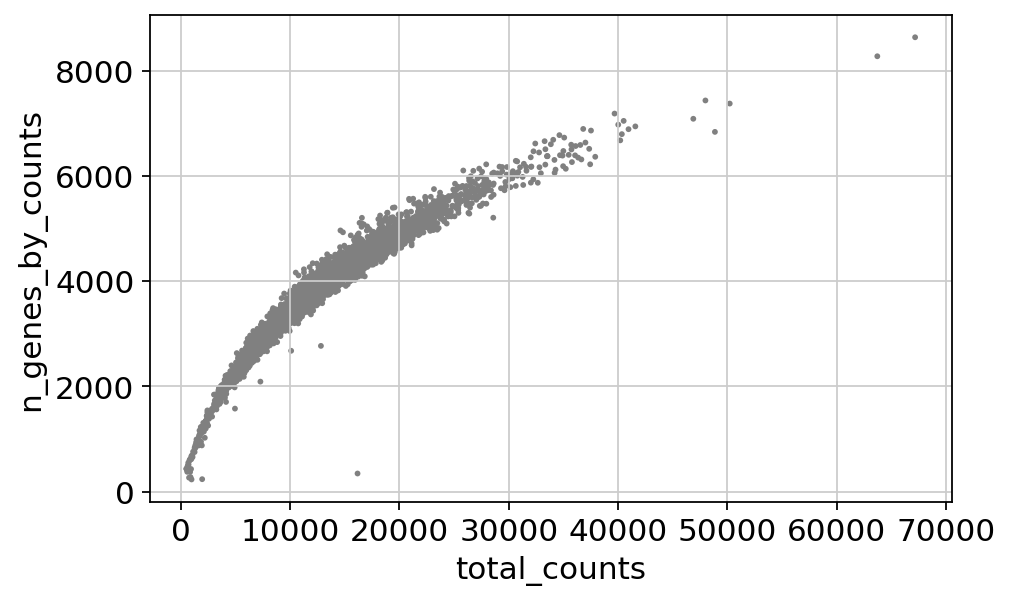

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [12]:
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.n_genes_by_counts < 7500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
print(adata)

View of AnnData object with n_obs × n_vars = 4296 × 16899
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [13]:
adata.write('../ann_data/E14_hom_qc.h5ad') 

In [14]:
# Transpose and write to csv for cellassign
df = pd.DataFrame(adata.X.transpose())
df.index = adata.var_names
df.columns = adata.obs_names
df.to_csv('../ann_data/E14_hom_qc.csv')

In [ ]:
# adata = sc.read('../ann_data/E14_hom_qc.h5ad') # run this to start from here

Total-count normalize (library-size correct) the data matrix **X** to 40,000 genes per cell, so that counts become comparable among cells.

In [15]:
sc.pp.normalize_total(adata, target_sum=40000)

/home/marina/msc/dissertation/single_cell_analysis/.env/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


Logarithmize the data.

In [16]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


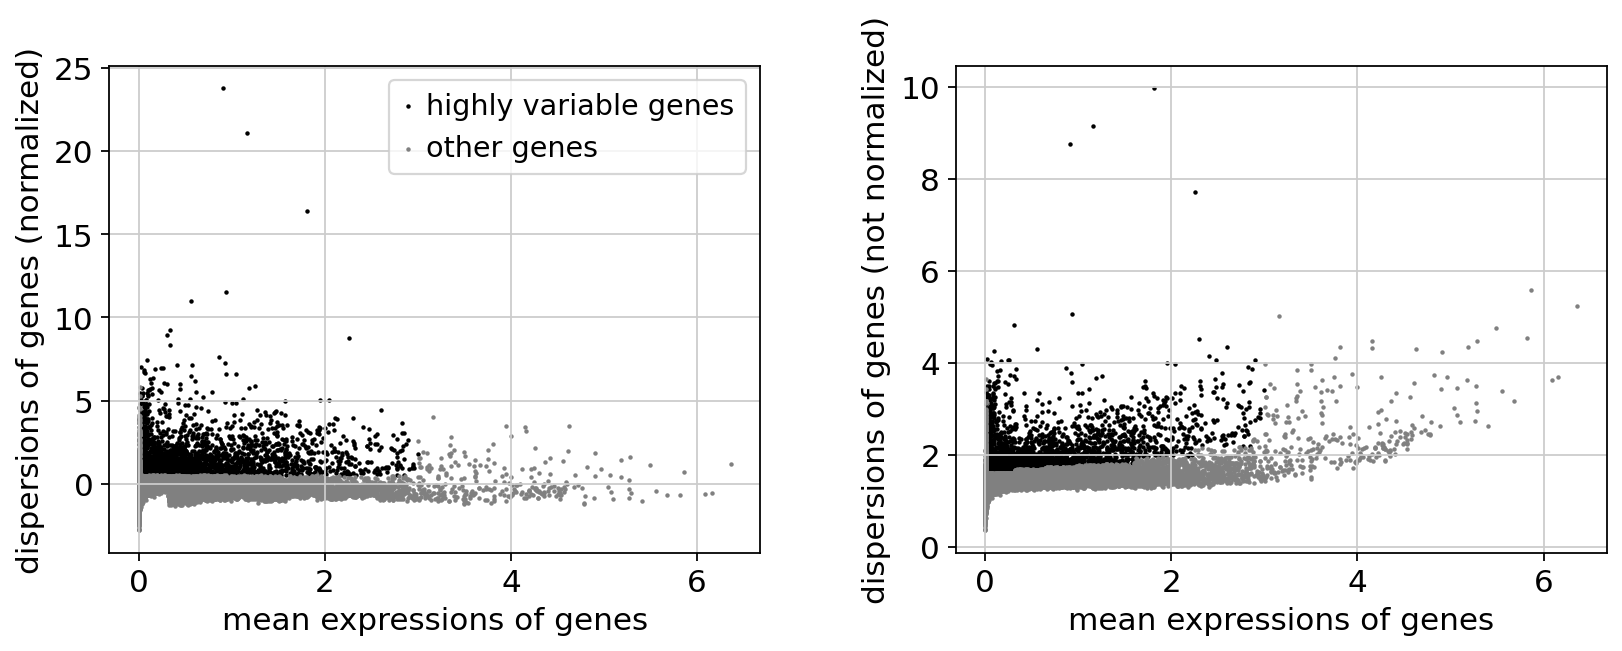

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata.raw = adata

Filter using the highly variable genes

In [20]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:37)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [22]:
sc.pp.scale(adata, max_value=10)

## Principal Component Analysis

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


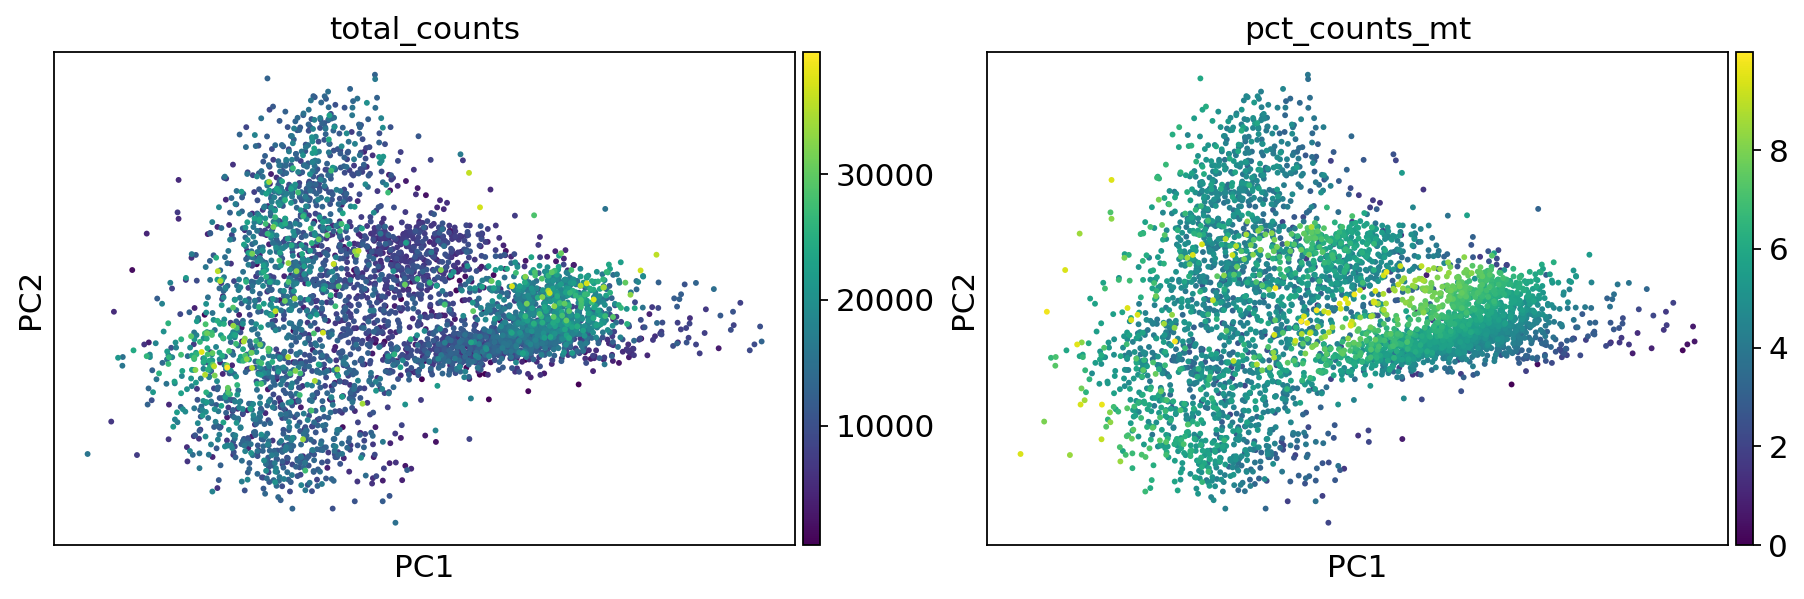

In [24]:
sc.pl.pca(adata, color=['total_counts', 'pct_counts_mt'])

In [25]:
print(adata)

AnnData object with n_obs × n_vars = 4296 × 2631
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


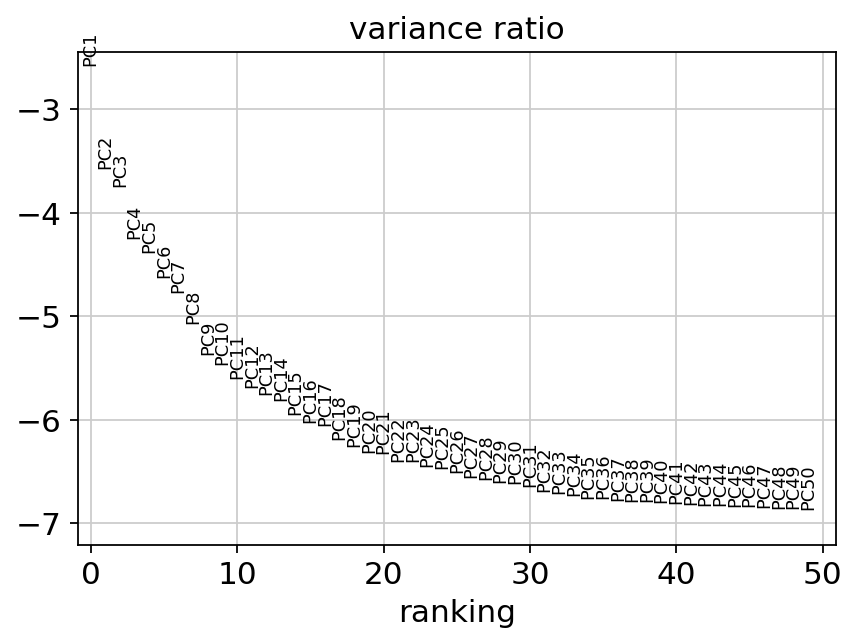

In [26]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Cell Cycle Scoring and Regression

Check cell cycle effect on the dataset

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    458 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    418 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


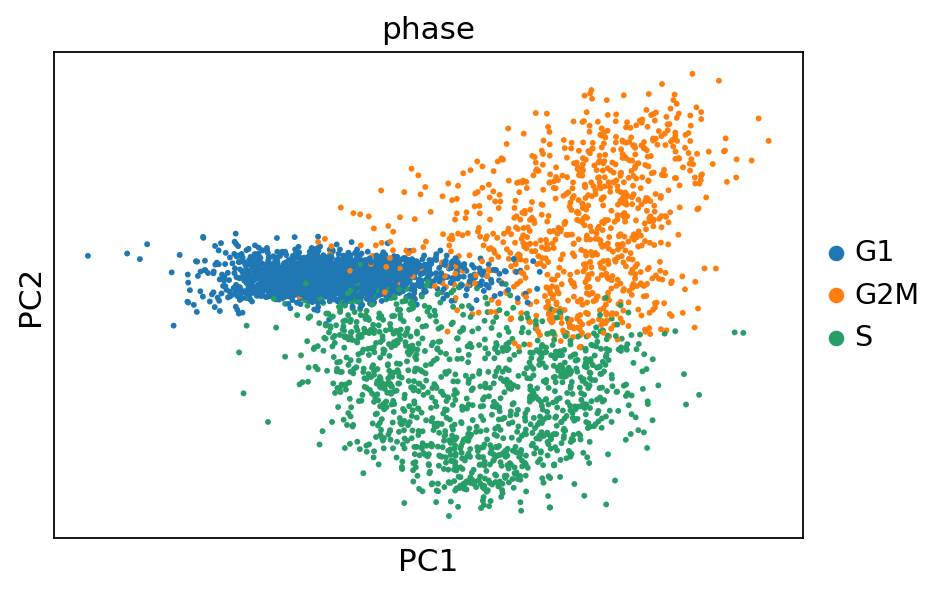

In [27]:
# Load cell cycle genes from file and split into S and G2M genes
cell_cycle_genes = [x.strip().lower().capitalize() for x in open('../preprocessing/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

# Perform cell cycle scoring
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
cc_phase = adata.obs.phase
adata_cc_genes = adata[:, cell_cycle_genes]  # Subset of the data using only the cell cycle phase genes

sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

Regress out S score and G2M score

regressing out ['S_score', 'G2M_score', 'pct_counts_mt']


... storing 'phase' as categorical


    finished (0:00:40)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


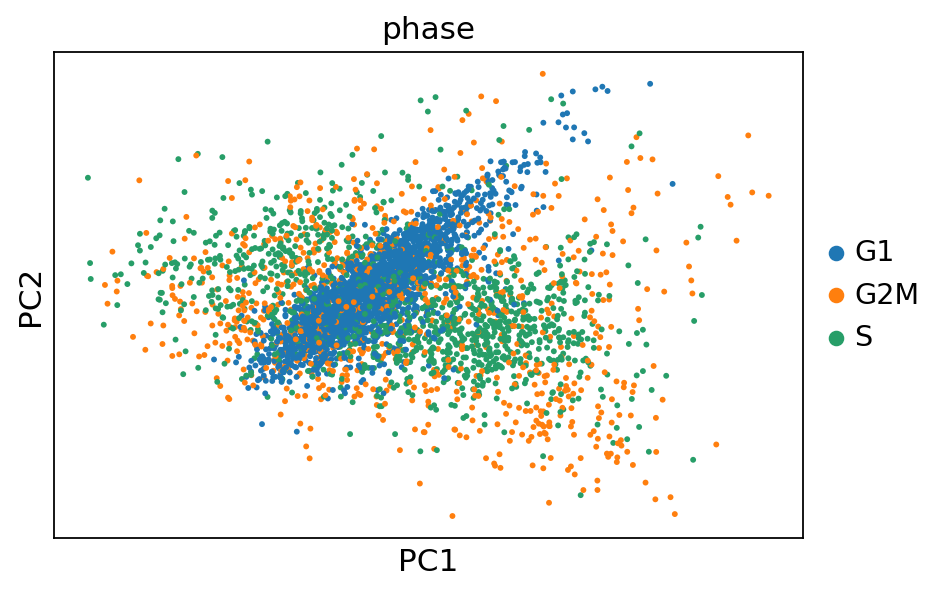

In [28]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score', 'pct_counts_mt'])
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

# Reproject dataset using the cell cycle genes to check that the cell cycle effect is now not present.
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## Neighbourhood graph using UMAP

We compute the neighbourhood graph of cells using the PCA representation of the data matrix and use UMAP to embed the graph into 2 dimensions

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [30]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


### Cell types

1. Neural progenitors: Pax6, Vim, Sox2
2. Intermediate progenitors: Eomes, Btg2,
3. Post-mitotic neurons: Tbr1, Sox5

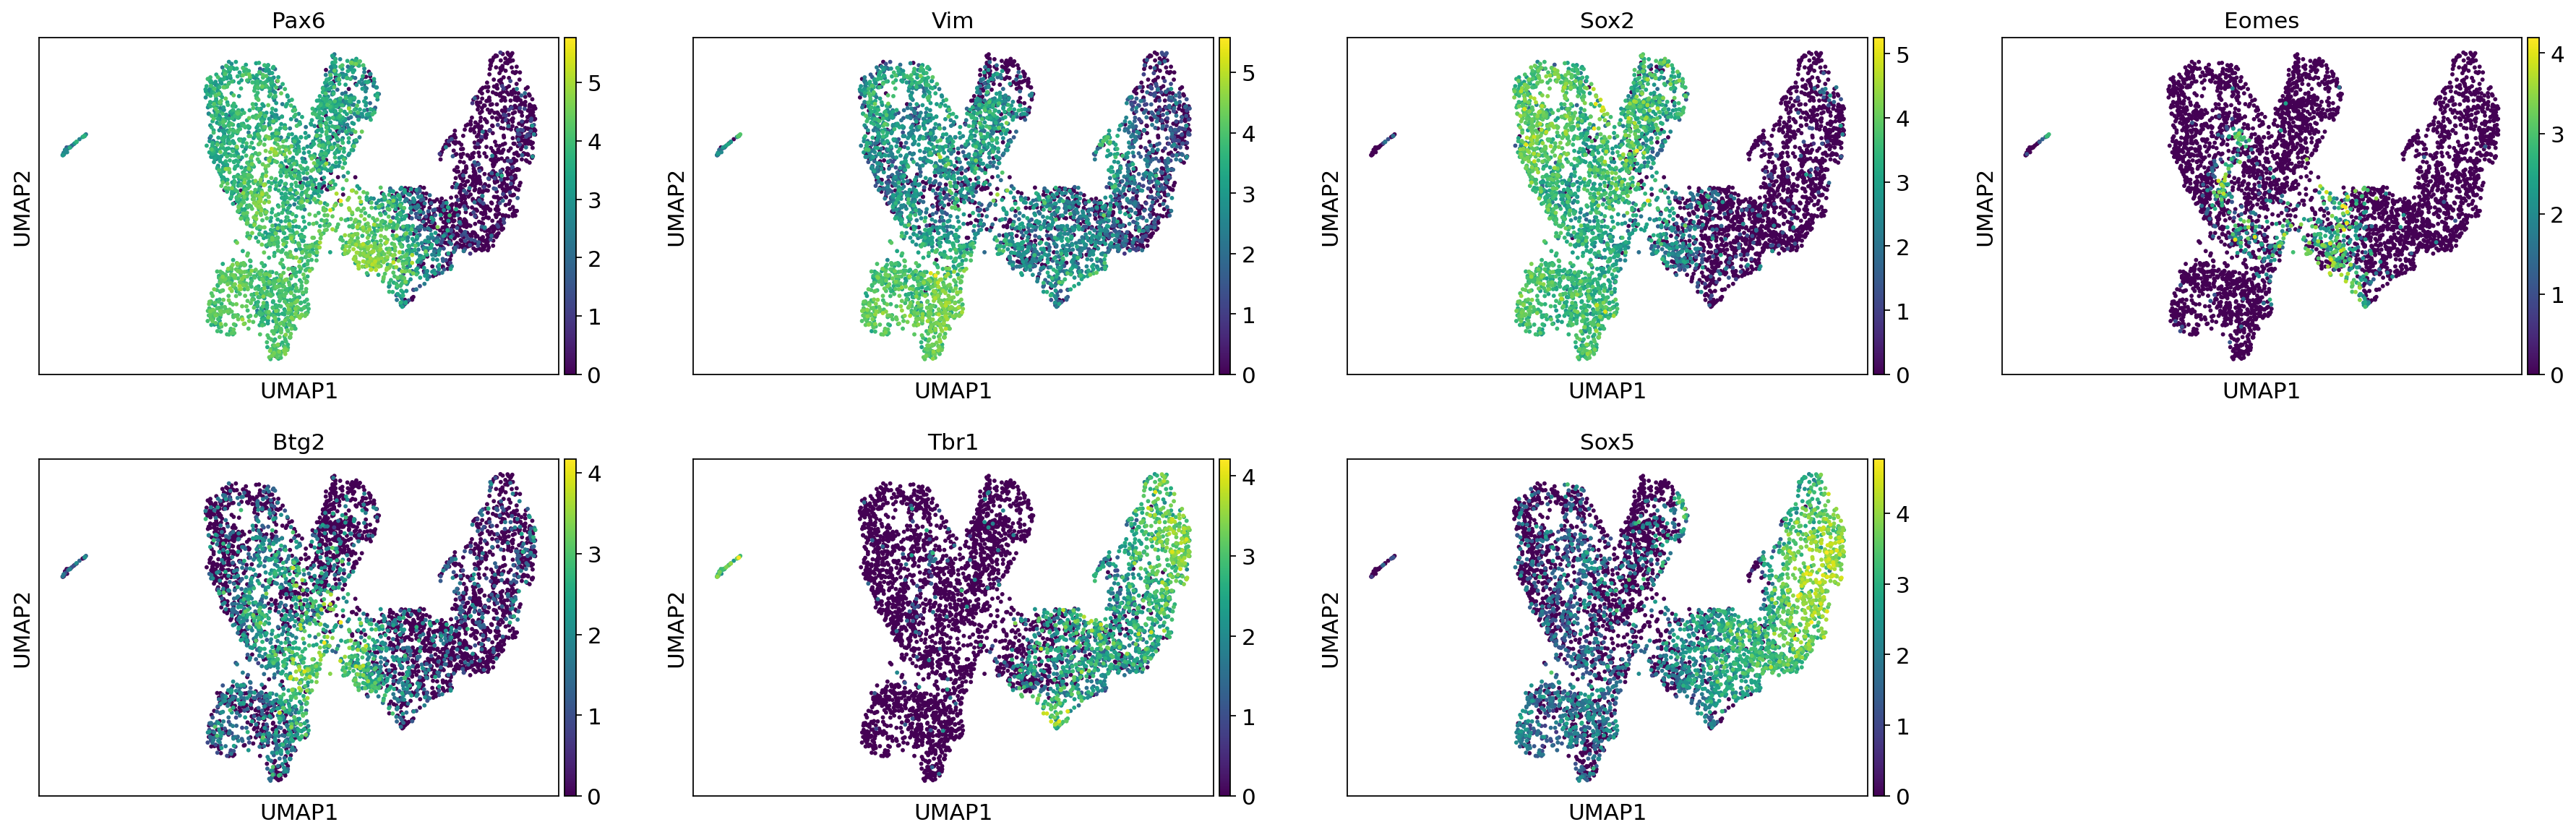

In [31]:
neural_progen = ['Pax6', 'Vim', 'Sox2']
intermediate_progen = ['Eomes', 'Btg2']
post_mitotic = ['Tbr1', 'Sox5']
sc.pl.umap(adata, color=neural_progen+intermediate_progen+post_mitotic)

Ectopic marker genes: 'Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3'

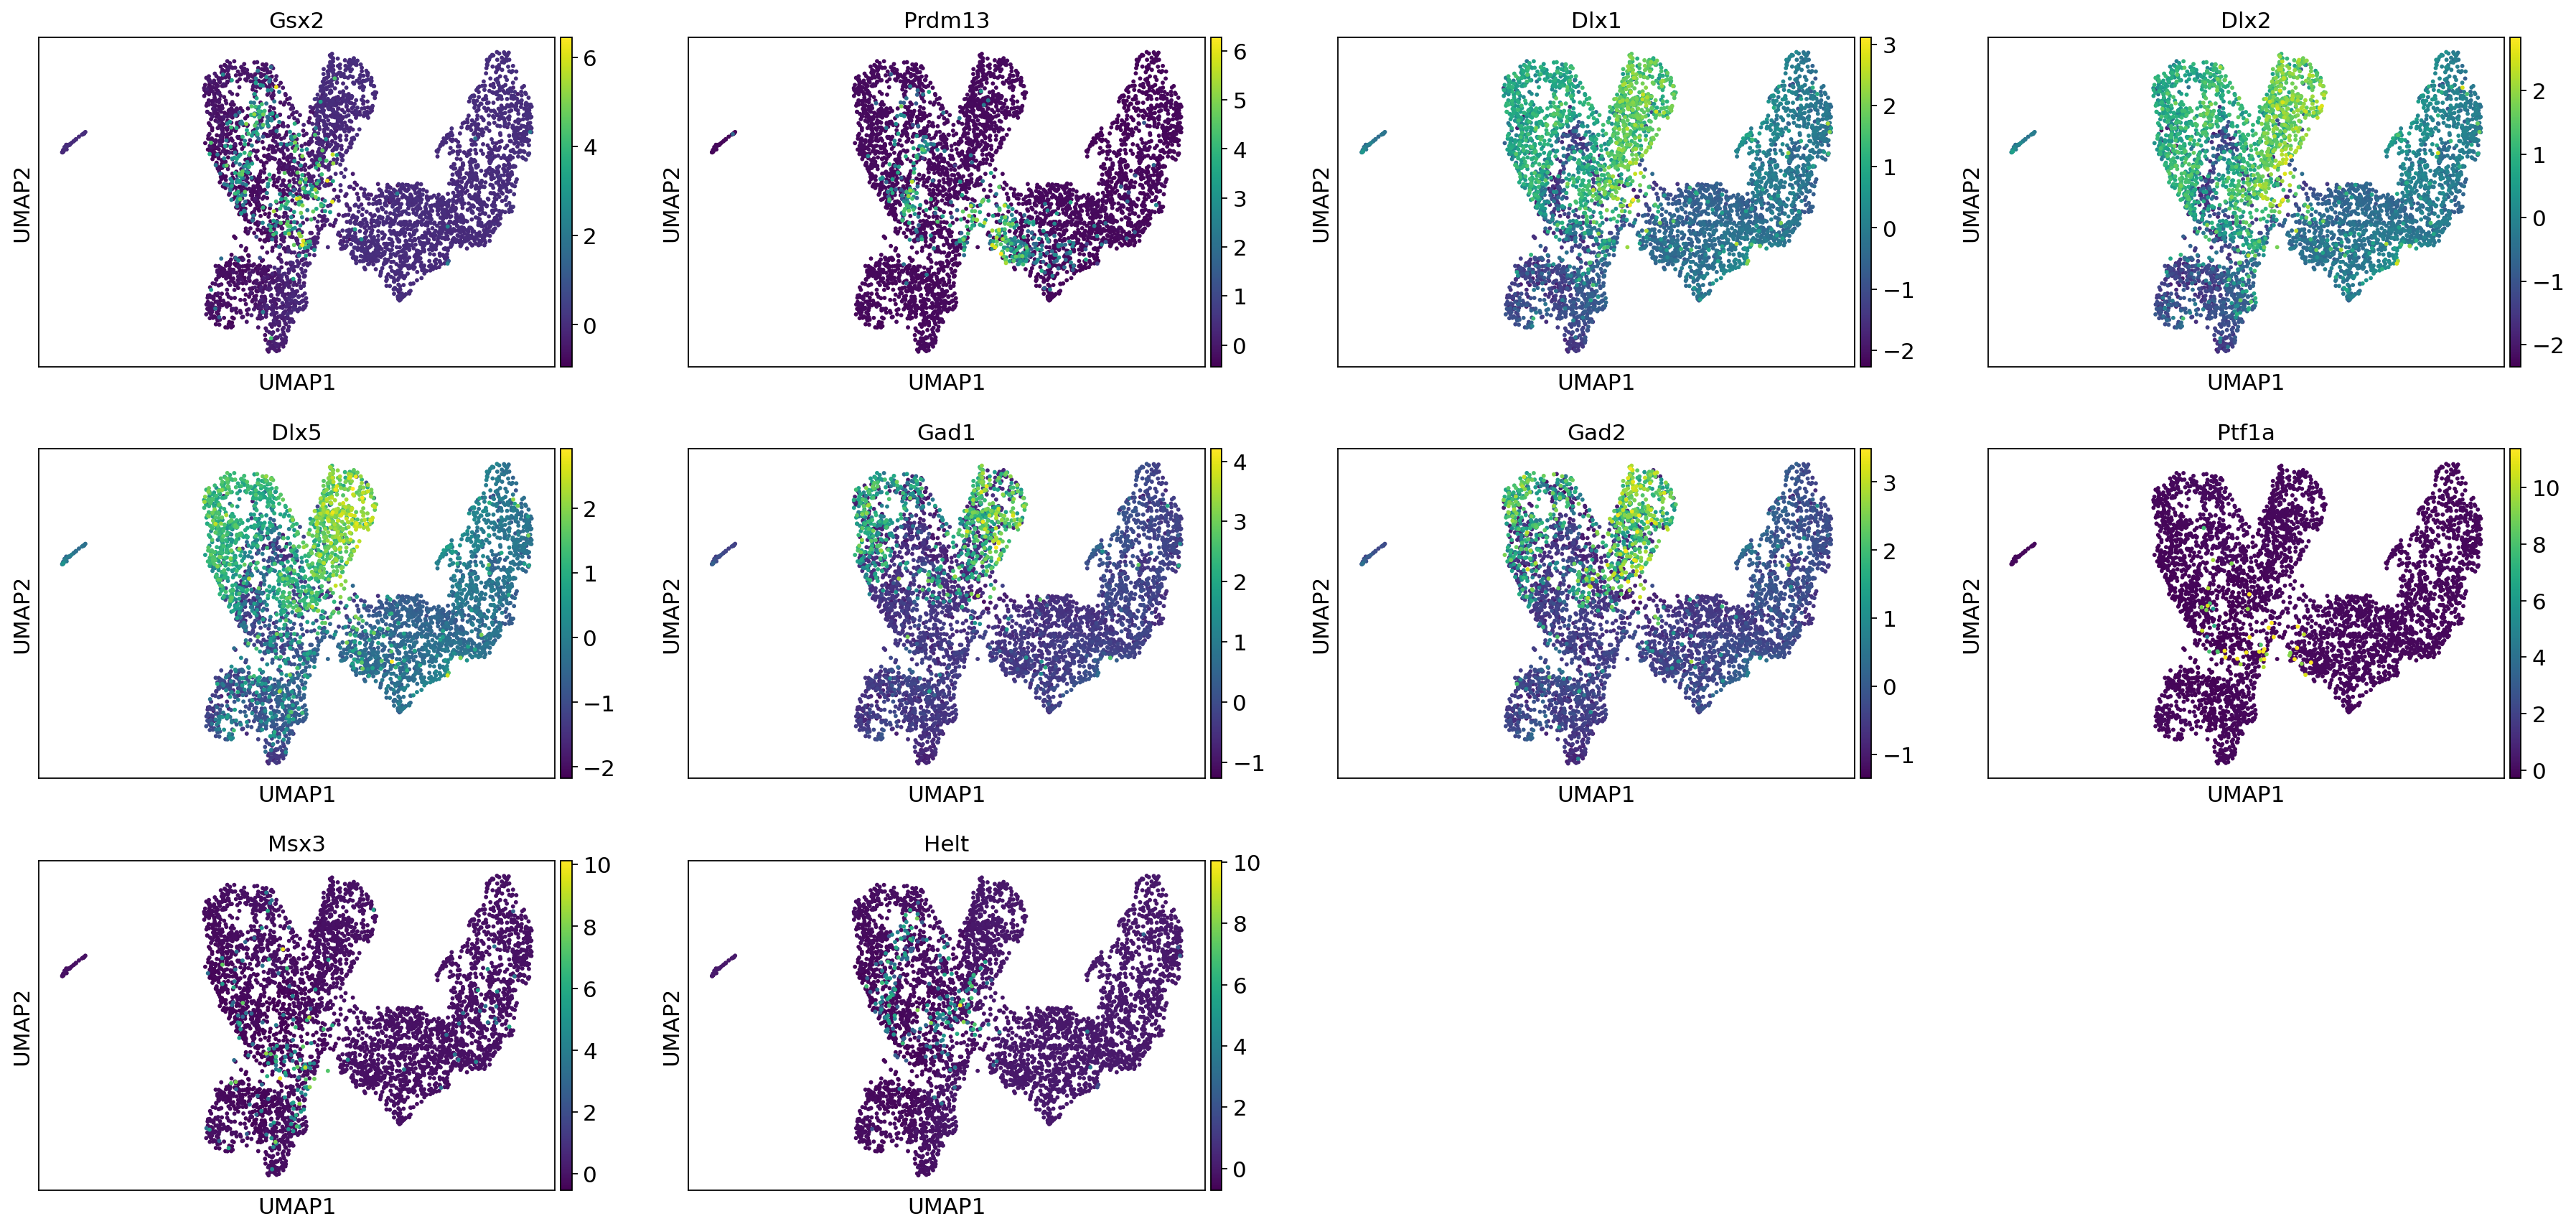

In [32]:
ectopic_marker_genes = [ 'Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt']
sc.pl.umap(adata, color=ectopic_marker_genes, use_raw=False)

## Clustering the neighborhood graph using the Leiden graph-clustering method

In [33]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


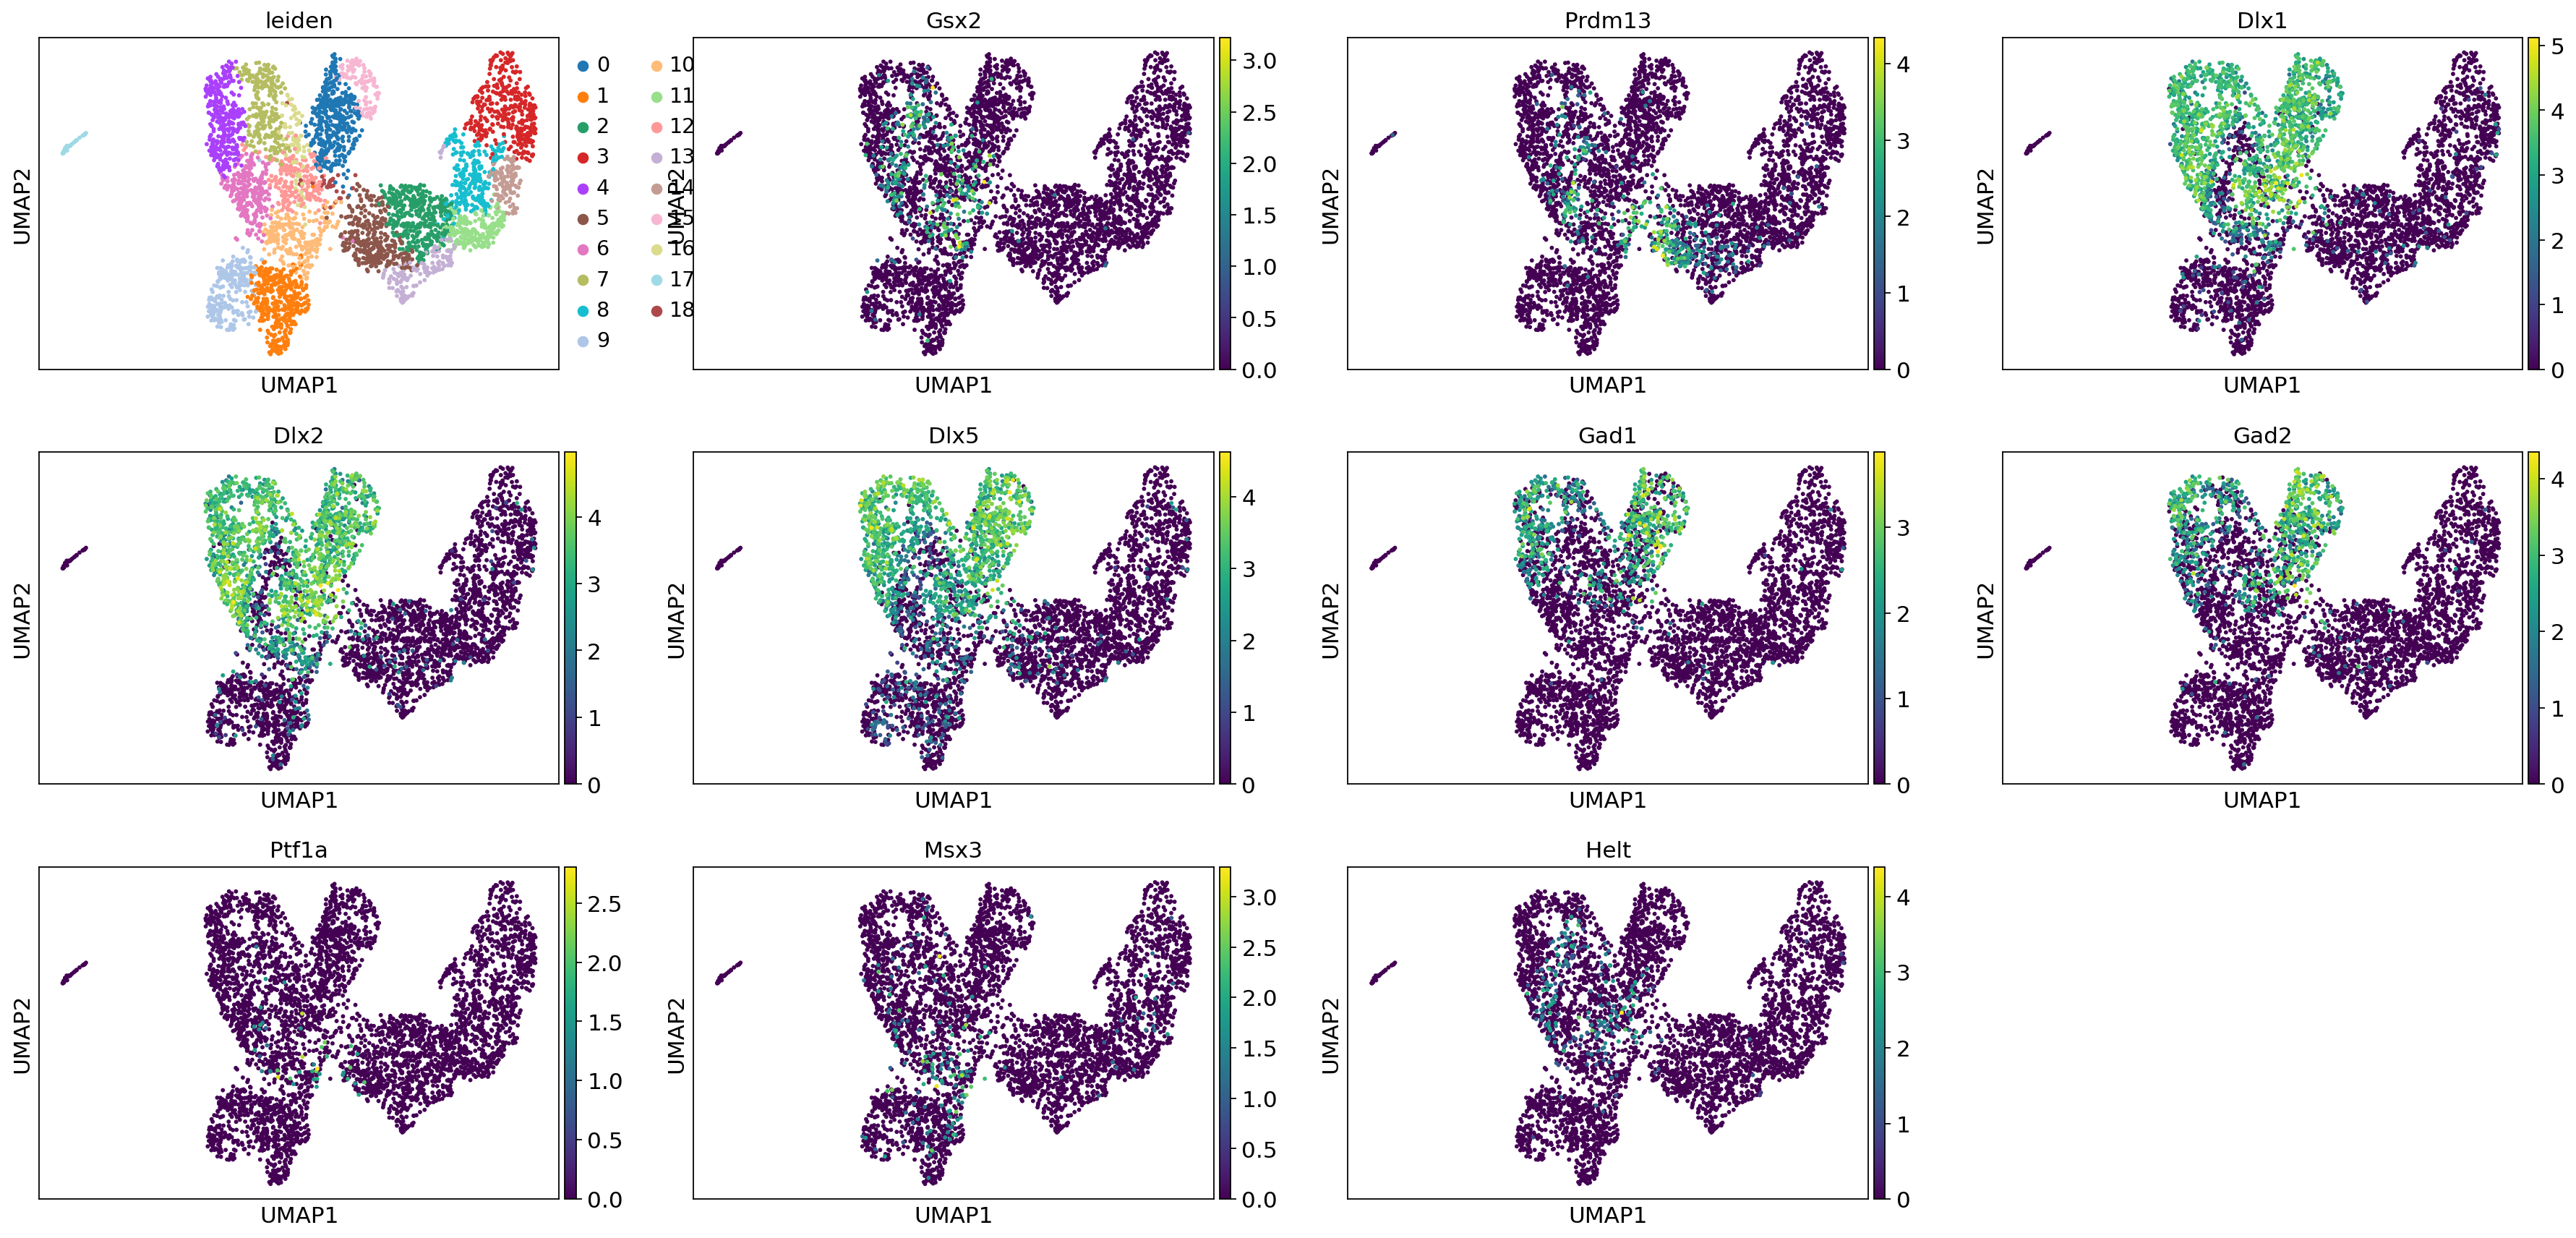

In [34]:
sc.pl.umap(adata, color=['leiden']+ectopic_marker_genes)